<a href="https://colab.research.google.com/github/Tanay2109/Mastering-Pac_Man-a-DQN-based-Approach/blob/main/Optimized_DQN_for_Pac_Man.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 Install dependencies (Run this only once)
!pip install gym[atari] ale-py autorom imageio
!AutoROM --accept-license

# 📦 Imports
import gym
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import cv2
from IPython.display import HTML
from base64 import b64encode
import imageio

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827730 sha256=392defe630489f63ebbe21728ad23f7b9939f51035e973bf2497f8841b69f0ed
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.2
    Uninstalling ale-py-0.10.2:
      Successfully uninstalled 

Episode 0, Reward: 500, Epsilon: 0.98
Episode 10, Reward: 280, Epsilon: 0.85
Episode 20, Reward: 160, Epsilon: 0.73
Episode 30, Reward: 270, Epsilon: 0.63
Episode 40, Reward: 700, Epsilon: 0.54
Episode 50, Reward: 460, Epsilon: 0.46
Episode 60, Reward: 430, Epsilon: 0.40
Episode 70, Reward: 420, Epsilon: 0.34
Episode 80, Reward: 980, Epsilon: 0.29
Episode 90, Reward: 510, Epsilon: 0.25
Episode 100, Reward: 420, Epsilon: 0.22
Episode 110, Reward: 430, Epsilon: 0.19
Episode 120, Reward: 330, Epsilon: 0.16
Episode 130, Reward: 1540, Epsilon: 0.14
Episode 140, Reward: 1110, Epsilon: 0.12
Episode 150, Reward: 280, Epsilon: 0.10
Episode 160, Reward: 800, Epsilon: 0.10
Episode 170, Reward: 680, Epsilon: 0.10
Episode 180, Reward: 540, Epsilon: 0.10
Episode 190, Reward: 250, Epsilon: 0.10


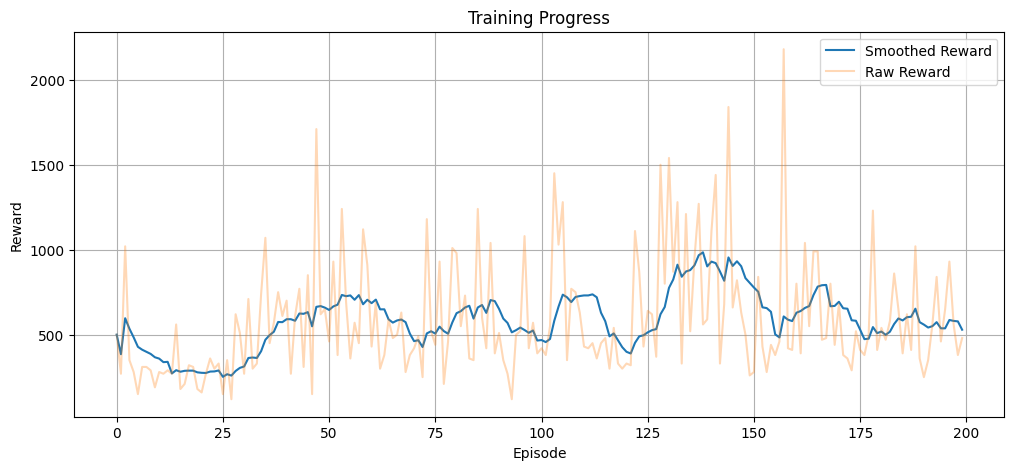

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [ ]:
# 🌍 Environment
env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
n_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔧 Preprocessing
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84))
    return np.expand_dims(resized, axis=0).astype(np.float32)

# 🧠 Simplified CNN
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = x / 255.0
        return self.model(x)

# 🔁 Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (np.stack(states), actions, rewards, np.stack(next_states), dones)

    def __len__(self):
        return len(self.buffer)

# 🎮 Epsilon-Greedy Action
def select_action(state, policy_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state).argmax().item()

# 🚀 Training Function
def train_dqn(env, episodes=200, gamma=0.99, batch_size=32,
              buffer_limit=5000, learning_rate=1e-4, target_update=3):

    policy_net = DQN(n_actions).to(device)
    target_net = DQN(n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayBuffer(buffer_limit)

    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.985
    rewards = []

    for episode in range(episodes):
        obs = preprocess_frame(env.reset()[0])
        total_reward = 0
        done = False

        while not done:
            action = select_action(obs, policy_net, epsilon, n_actions)
            next_frame, reward, done, truncated, _ = env.step(action)
            next_obs = preprocess_frame(next_frame)

            memory.push(obs, action, reward, next_obs, done)
            obs = next_obs
            total_reward += reward

            if len(memory) >= batch_size:
                states, actions, rewards_, next_states, dones = memory.sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_ = torch.FloatTensor(rewards_).to(device)
                dones = torch.FloatTensor(dones).to(device)

                q_values = policy_net(states).gather(1, actions).squeeze()
                next_q = target_net(next_states).max(1)[0]
                expected_q = rewards_ + (1 - dones) * gamma * next_q

                loss = nn.MSELoss()(q_values, expected_q)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {total_reward:.0f}, Epsilon: {epsilon:.2f}")

    return policy_net, rewards

# 📊 Live Training Plot
def plot_rewards(reward_log, window=10):
    smoothed = [np.mean(reward_log[max(0, i - window):(i + 1)]) for i in range(len(reward_log))]
    plt.figure(figsize=(12, 5))
    plt.plot(smoothed, label="Smoothed Reward")
    plt.plot(reward_log, alpha=0.3, label="Raw Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.title("Training Progress")
    plt.grid()
    plt.show()

# 🎥 Save Gameplay Video
def record_video(env, model, path="pacman.mp4", max_frames=500):
    frames = []
    obs = preprocess_frame(env.reset()[0])
    for _ in range(max_frames):
        frame = env.render()
        frames.append(frame)
        action = select_action(obs, model, epsilon=0.0, n_actions=n_actions)
        next_frame, _, done, truncated, _ = env.step(action)
        obs = preprocess_frame(next_frame)
        if done:
            break
    imageio.mimsave(path, frames, fps=30)
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

# 🏁 Train the Agent
trained_model, reward_log = train_dqn(env)

# 📈 Visualize Reward Trend
plot_rewards(reward_log)

# 🎬 Watch Agent Performance
record_video(env, trained_model)
